In [14]:
### I WILL PUT THE SOLVER CODE HERE AND WE CAN MERGE TO THE MAIN FILE ONCE ITS WORKING
#IMPORT DEPENDENCIES
import pandas as pd
import yfinance as yf
import datetime
import numpy as np
from scipy.optimize import minimize
from MCForecastTools import MCSimulation
import warnings


In [15]:
# Suppress the specific PerformanceWarning
warnings.filterwarnings('ignore', message='DataFrame is highly fragmented', category=pd.errors.PerformanceWarning)

In [2]:
#APIs
# Define the list of stock ticker symbols
tickers = ['AGG', 'BNDX', 'SPY', 'IVW', 'IVE', 'BTC-USD', 'ETH-USD']

# Calculate the start date (three years ago from today)
start_date = datetime.datetime.now() - datetime.timedelta(days=1095)

# Initialize an empty dataframe to store the Close columns for each ticker
new_df = pd.DataFrame()

# Initialize an empty list to store the column names of Close prices for each ticker
ticker_closes = []

In [3]:
#Past 3 years of data into data frames
# Iterate over each ticker symbol
for ticker in tickers:
    # Fetch historical stock price data for the current ticker
    stock_data = yf.download(ticker, start=start_date, end=datetime.datetime.now())
    
    # Extract the 'Close' column and rename it for the current ticker
    close_column = stock_data[['Close']].rename(columns={'Close': f'{ticker}_Close'})
    
    # Compute the daily returns and insert them to the left of the corresponding ticker's Close column
    daily_returns = close_column.pct_change().rename(columns={f'{ticker}_Close': f'{ticker}_Daily_Return'})
    new_df = pd.concat([daily_returns, new_df], axis=1)
    
    # Append the Close column name for the current ticker to the ticker_closes list
    ticker_closes.append(f'{ticker}_Close')

# Drop rows containing NaNs from the new_df dataframe
new_df.dropna(inplace=True)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
## Feel free to adjust or send feedback if the code could be better or be more precise to what is needed:

span = len(new_df)  # Adjust the span for three years of historical data

# Calculate the annualized exponentially weighted mean return for each asset
annualized_mean_return = new_df.ewm(span=span).mean().iloc[-1] * 252

# Calculate the annualized exponentially weighted standard deviation (risk) for each asset
annualized_std_dev = new_df.ewm(span=span).std().iloc[-1] * np.sqrt(252)

# Display annualized risk and return for each asset
for ticker in tickers:
    print(f'{ticker}:')
    print(f'Annualized Mean Return: {annualized_mean_return[f"{ticker}_Daily_Return"]:.2%}')
    print(f'Annualized Risk (Standard Deviation): {annualized_std_dev[f"{ticker}_Daily_Return"]:.2%}')
    print()

#print(new_df)

AGG:
Annualized Mean Return: -3.81%
Annualized Risk (Standard Deviation): 7.04%

BNDX:
Annualized Mean Return: -2.68%
Annualized Risk (Standard Deviation): 6.05%

SPY:
Annualized Mean Return: 14.10%
Annualized Risk (Standard Deviation): 16.07%

IVW:
Annualized Mean Return: 15.95%
Annualized Risk (Standard Deviation): 19.57%

IVE:
Annualized Mean Return: 11.90%
Annualized Risk (Standard Deviation): 14.19%

BTC-USD:
Annualized Mean Return: 33.08%
Annualized Risk (Standard Deviation): 51.55%

ETH-USD:
Annualized Mean Return: 14.15%
Annualized Risk (Standard Deviation): 61.11%



In [5]:
# Create a dictionary with calculated values
assets_data = {
    'Ticker': tickers,
    'Annualized_Mean_Return': [annualized_mean_return[f"{ticker}_Daily_Return"] for ticker in tickers],
    'Annualized_Std_Dev': [annualized_std_dev[f"{ticker}_Daily_Return"] for ticker in tickers]
}

# Convert the dictionary into a DataFrame
individual_assets = pd.DataFrame(assets_data)

# Print the DataFrame
print(individual_assets)

    Ticker  Annualized_Mean_Return  Annualized_Std_Dev
0      AGG               -0.038076            0.070408
1     BNDX               -0.026793            0.060533
2      SPY                0.140950            0.160701
3      IVW                0.159465            0.195740
4      IVE                0.118993            0.141944
5  BTC-USD                0.330788            0.515528
6  ETH-USD                0.141504            0.611120


In [6]:
agg_mean_return = individual_assets['Annualized_Mean_Return']

# Define the objective function to minimize
def objective_function(weights, mean_returns, target_return):
    # Calculate the portfolio return
    portfolio_return = np.dot(mean_returns, weights)
    # Calculate the squared difference between the portfolio return and the target return
    return (portfolio_return - target_return) ** 2

# Define initial guess for weights
initial_guess = np.ones(len(agg_mean_return)) / len(agg_mean_return)  # Equal weights initially

# List of target return percentages
target_returns = [0.05, 0.10, 0.15, .20, .25, .30, 0.35]  # Add more target returns as needed

# Initialize an empty dataframe to store the results
target_weights = pd.DataFrame()

# Define constraint function to ensure weights sum to 1
def constraint(weights):
    return np.sum(weights) - 1

# Loop through each target return
for i, target_return in enumerate(target_returns, start=1):
    # Perform optimization
    result = minimize(objective_function, initial_guess, args=(agg_mean_return, target_return), method='SLSQP', bounds=[(0, 1)] * len(agg_mean_return), constraints={'type': 'eq', 'fun': constraint})

    # Print optimization result
    print(f"Optimization Result for Target Return {target_return}:")
    print(result)
    print("Optimal solution:", result.x)

    # Round the optimal solution to a certain number of decimal places
    rounded_solution = np.round(result.x, decimals=4)

    # Ensure that the rounded weights sum up to 1
    rounded_solution /= np.sum(rounded_solution)

    # Print the rounded and normalized solution
    print("Optimal solution (rounded and normalized):", rounded_solution)

    # Store the rounded and normalized solution in the dataframe
    target_weights[f'{target_return}_weights'] = rounded_solution

# Print the dataframe with the results
print("Target Weights:")
print(target_weights.columns)


Optimization Result for Target Return 0.05:
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 6.927343780974063e-19
       x: [ 2.638e-01  2.547e-01  1.198e-01  1.049e-01  1.375e-01
            0.000e+00  1.194e-01]
     nit: 6
     jac: [ 8.499e-11  5.530e-11  6.141e-11  1.135e-10  1.291e-11
            1.080e-09  6.282e-11]
    nfev: 48
    njev: 6
Optimal solution: [0.26375593 0.25468341 0.11980958 0.10492257 0.13746439 0.
 0.11936412]
Optimal solution (rounded and normalized): [0.26377362 0.25467453 0.11978802 0.10488951 0.13748625 0.
 0.11938806]
Optimization Result for Target Return 0.1:
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 3.947315795875454e-18
       x: [ 1.732e-01  1.710e-01  1.384e-01  1.348e-01  1.427e-01
            1.016e-01  1.383e-01]
     nit: 3
     jac: [-7.402e-05 -5.209e-05  2.740e-04  3.100e-04  2.313e-04
            6.431e-04  2.751e-04]
    nfev: 25
    njev: 3
Optimal solution: [0.1

In [8]:
#CONFIRM PORT RETURNS MATCH TARGETS FROM SOLVER
for i, target_weight_column in enumerate(target_weights.columns):
    
    # Calculate portfolio return using sum product
    portfolio_return = (np.dot(target_weights[target_weight_column], individual_assets['Annualized_Mean_Return'])) * 100

    print("Portfolio Return:", round(portfolio_return, 2))

Portfolio Return: 5.0
Portfolio Return: 10.0
Portfolio Return: 15.0
Portfolio Return: 20.0
Portfolio Return: 25.0
Portfolio Return: 30.0
Portfolio Return: 33.08


In [10]:
# Calculate the correlation matrix
correlation_matrix = new_df.corr()
#print(correlation_matrix)

# Define the column names for the weights based on target return percentages
weight_columns = ['0.05_weights', '0.1_weights', '0.15_weights', '0.2_weights', '0.25_weights', '0.3_weights', '0.35_weights']

# Access the values of these columns and store them in the weights variable
weights = target_weights[weight_columns].values

# print(weights)
# print(weights.T.shape)
# Define a function to calculate portfolio standard deviation
def calculate_portfolio_std(weights, correlation_matrix, std_deviations):
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(correlation_matrix, weights)) * np.sum(std_deviations ** 2))
    return portfolio_std

# Create a new DataFrame to store portfolio standard deviations
port_stds = pd.DataFrame(index=[f"Portfolio {i}" for i in range(1, 8)], columns=['Portfolio_Std_Dev'])

# Iterate over each row in the DataFrame
for index, row in target_weights.iterrows():
    # Extract weights and standard deviations from the current row
    weights = row[weight_columns].values
for index, row in individual_assets.iterrows():
    std_deviations = row['Annualized_Std_Dev']

    portfolio_std = calculate_portfolio_std(weights, correlation_matrix, std_deviations)
    
    # Add portfolio standard deviation to the port_stds DataFrame
    port_stds.at[f"Portfolio {index + 1}", 'Portfolio_Std_Dev'] = portfolio_std

# Print the DataFrame with portfolio standard deviations
print(port_stds)

            Portfolio_Std_Dev
Portfolio 1          0.039682
Portfolio 2          0.034116
Portfolio 3           0.09057
Portfolio 4          0.110319
Portfolio 5          0.079999
Portfolio 6           0.29055
Portfolio 7          0.344425


In [12]:
##NOTE were only going to use 10-30% Return Portfolios for analysis

for i, target_weight_column in enumerate(target_weights.columns[1:-1]):
    # Calculate portfolio return using sum product
    portfolio_return = (np.dot(target_weights[target_weight_column], individual_assets['Annualized_Mean_Return'])) * 100
    
    # Calculate portfolio Sharpe ratio
    portfolio_std_dev = port_stds.iloc[i + 1]['Portfolio_Std_Dev']
    portfolio_sharpe = portfolio_return / (portfolio_std_dev * 100)
    
    # Print portfolio return and Sharpe ratio
    print(f"Portfolio Return: {round(portfolio_return, 2)}%")
    print("Portfolio Sharpe:", round(portfolio_sharpe, 2))
    print('--------')


Portfolio Return: 10.0%
Portfolio Sharpe: 2.93
--------
Portfolio Return: 15.0%
Portfolio Sharpe: 1.66
--------
Portfolio Return: 20.0%
Portfolio Sharpe: 1.81
--------
Portfolio Return: 25.0%
Portfolio Sharpe: 3.13
--------
Portfolio Return: 30.0%
Portfolio Sharpe: 1.03
--------


In [26]:
# Set start and end datetimes between now and 4 years ago.
start_date = datetime.datetime.now() - datetime.timedelta(days=1095)

# Set the ticker information
tickers = ['AGG', 'BNDX', 'SPY', 'IVW', 'IVE', 'BTC-USD', 'ETH-USD']

monte_df = pd.DataFrame()
ticker_closes = []

##NOTE - we'll hardcode these for now... we can figure out what else to do w/them later
# portfolio_weights = target_weights
# print(target_weights)

portfolio_target_weights = [target_weights.iloc[:, i].values.tolist() for i in range(len(target_weights.columns))]
# print(portfolio_target_weights)

# Iterate over each ticker symbol
for ticker in tickers:
    # Fetch historical stock price data for the current ticker
    stock_data = yf.download(ticker, start=start_date, end=datetime.datetime.now())
    

    stock_data = stock_data[['Close']].rename(columns={'Close': 'close'})
  
    existing_columns = stock_data.columns

    # Create a MultiIndex with a single top level and the existing column names as the second level
    multi_index = pd.MultiIndex.from_product([[ticker], existing_columns])

    # Set the MultiIndex as the columns of the DataFrame
    stock_data.columns = multi_index

    monte_df = pd.concat([stock_data, monte_df], axis=1)
    
    # Append the Close column name for the current ticker to the ticker_closes list
    ticker_closes.append(f'{ticker}_Close')

# Drop rows containing NaNs from the new_df dataframe
monte_df.dropna(inplace=True)

monte_df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,ETH-USD,BTC-USD,IVE,IVW,SPY,BNDX,AGG
,close,close,close,close,close,close,close
Date,,,,,,,
2021-05-10,3952.293945,55859.796875,150.610001,67.940002,417.940002,56.910000,114.430000
2021-05-11,4168.701172,56704.574219,148.570007,67.650002,414.209991,56.779999,114.180000
2021-05-12,3785.848633,49150.535156,145.990005,65.959999,405.410004,56.619999,113.779999
2021-05-13,3715.148438,49716.191406,147.979996,66.660004,410.279999,56.639999,114.040001
2021-05-14,4079.057373,49880.535156,149.820007,67.889999,416.579987,56.709999,114.300003
...,...,...,...,...,...,...,...
2024-04-30,3012.286865,60636.855469,178.789993,81.239998,501.980011,48.410000,95.230003
2024-05-01,2969.784668,58254.011719,178.360001,80.809998,500.350006,48.410000,95.269997


In [27]:
# Configure a Monte Carlo simulation to forecast specified years and num_sims cumulative returns

# specify the number of simulations to be run and the number of years to be forecast
num_sims = 1000
forecast_years = 5

MC_port_one = MCSimulation(monte_df, weights=portfolio_target_weights[1], num_simulation=num_sims, num_trading_days=252*forecast_years)

# Print the simulation input data
MC_port_one.portfolio_data.head()

ETH-USD                    BTC-USD                      IVE  \
                  close daily_return         close daily_return       close   
Date                                                                          
2021-05-10  3952.293945          NaN  55859.796875          NaN  150.610001   
2021-05-11  4168.701172     0.054755  56704.574219     0.015123  148.570007   
2021-05-12  3785.848633    -0.091840  49150.535156    -0.133217  145.990005   
2021-05-13  3715.148438    -0.018675  49716.191406     0.011509  147.979996   
2021-05-14  4079.057373     0.097953  49880.535156     0.003306  149.820007   

                               IVW                      SPY               \
           daily_return      close daily_return       close daily_return   
Date                                                                       
2021-05-10          NaN  67.940002          NaN  417.940002          NaN   
2021-05-11    -0.013545  67.650002    -0.004268  414.209991    -0.008925   
2021-05-12    -0.017366  65.959999    -0.024982  405.410004    -0.021245   
2021-05-13     0.013631  66.660004     0.010613  410.279999     0.012013   
2021-05-14     0.012434  67.889999     0.018452  416.579987     0.015355   

                 BNDX                      AGG               
                close daily_return       close daily_return  
Date                                                         
2021-05-10  56.910000          NaN  114.430000          NaN  
2021-05-11  56.779999    -0.002284  114.180000    -0.002185  
2021-05-12  56.619999    -0.002818  113.779999    -0.003503  
2021-05-13  56.639999     0.000353  114.040001     0.002285  
2021-05-14  56.709999     0.001236  114.300003     0.002280

<Axes: title={'center': '1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

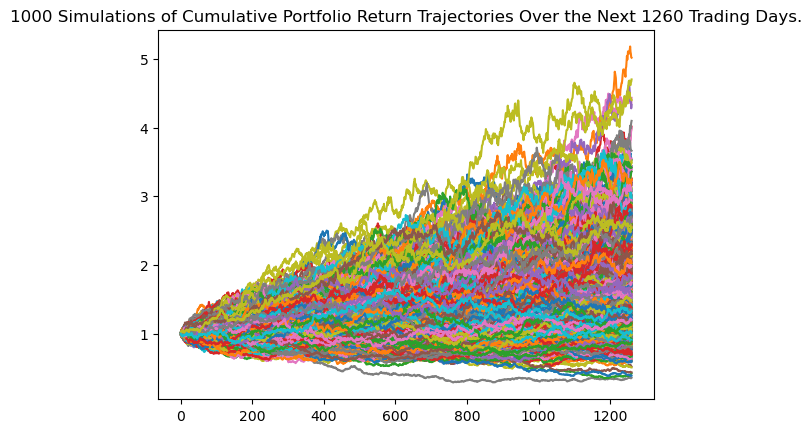

In [28]:
# Run a Monte Carlo simulation to forecast five years cumulative returns
### ***NOTE*** WE NEED TO USE HVPLOT
MC_port_one.plot_simulation()

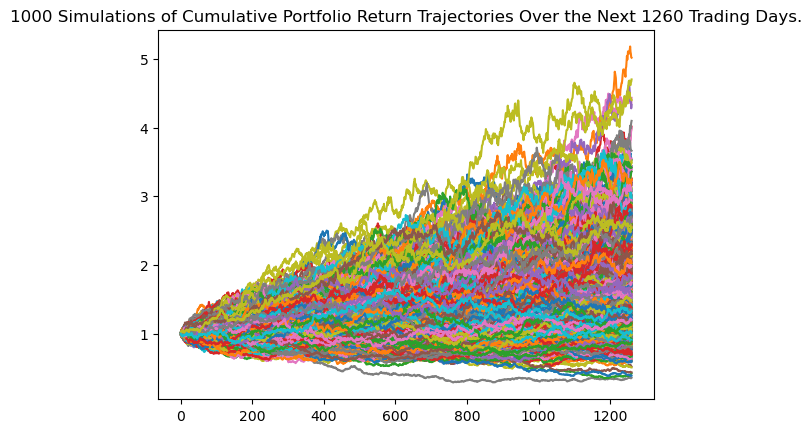

In [29]:
# Plot simulation outcomes
line_plot = MC_port_one.plot_simulation()

#change the _fiveyear_ sim in the string to reflect the sim length
line_plot.get_figure().savefig('MC_port_one_fiveyear_sim_plot.png', bbox_inches='tight')

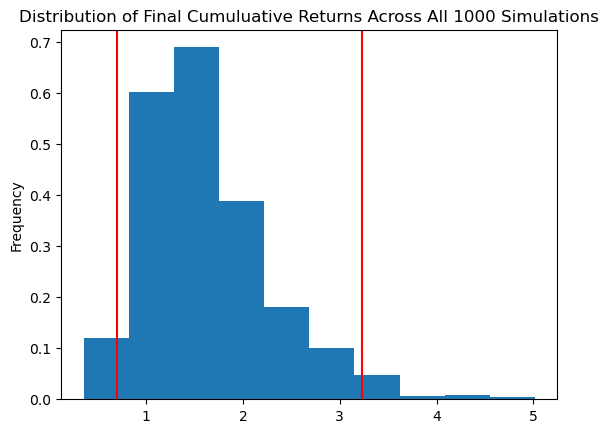

In [30]:
# Plot probability distribution and confidence intervals
dist_plot = MC_port_one.plot_distribution()

#change the _fiveyear_ sim in the string to reflect the sim length
dist_plot.get_figure().savefig('MC_port_one_fiveyear_dist_plot.png', bbox_inches = 'tight')

In [31]:
# Fetch summary statistics from the Monte Carlo simulation results

# Fetch summary statistics from the Monte Carlo simulation results
summary_metrics_port_one = MC_port_one.simulated_return.iloc[-1].describe()
ci_series_port_one = MC_port_one.confidence_interval
ci_series_port_one.index = ["95% CI Lower", "95% CI Upper"]

# Concatenate metrics and confidence interval series into a DataFrame
summary_df_port_one = pd.concat([summary_metrics_port_one, ci_series_port_one], axis=0)

# Print summary statistics with confidence intervals
print(summary_df_port_one)

count           1000.000000
mean               1.631442
std                0.653594
min                0.357143
25%                1.177869
50%                1.494910
75%                1.957496
max                5.016285
95% CI Lower       0.696924
95% CI Upper       3.231292
Name: 1260, dtype: float64


In [32]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments stocks
initial_investment = 15000
lower_bound_port_one = round((summary_df_port_one['95% CI Lower'] * initial_investment), 2)
upper_bound_port_one = round((summary_df_port_one['95% CI Upper'] * initial_investment), 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment}")
print(f"in the portofolio over the next 5 years will end within the range of ${lower_bound_port_one} and ${upper_bound_port_one}.")

sharpe_port_one = summary_df_port_one['mean']/summary_df_port_one['std']
print(f"this is your sharpe: {round(sharpe_port_one, 2)}, you make {round(sharpe_port_one,2)} units of return for every 1 unit of risk")

There is a 95% chance that an initial investment of $15000
in the portofolio over the next 5 years will end within the range of $10453.87 and $48469.38.
this is your sharpe: 2.5, you make 2.5 units of return for every 1 unit of risk


In [33]:
# Configure a Monte Carlo simulation to forecast specified years and num_sims cumulative returns

# specify the number of simulations to be run and the number of years to be forecast
num_sims = 1000
forecast_years = 5

MC_port_two = MCSimulation(monte_df, weights=portfolio_target_weights[2], num_simulation=num_sims, num_trading_days=252*forecast_years)

# Print the simulation input data
MC_port_two.portfolio_data.head()

ETH-USD                    BTC-USD                      IVE  \
                  close daily_return         close daily_return       close   
Date                                                                          
2021-05-10  3952.293945          NaN  55859.796875          NaN  150.610001   
2021-05-11  4168.701172     0.054755  56704.574219     0.015123  148.570007   
2021-05-12  3785.848633    -0.091840  49150.535156    -0.133217  145.990005   
2021-05-13  3715.148438    -0.018675  49716.191406     0.011509  147.979996   
2021-05-14  4079.057373     0.097953  49880.535156     0.003306  149.820007   

                               IVW                      SPY               \
           daily_return      close daily_return       close daily_return   
Date                                                                       
2021-05-10          NaN  67.940002          NaN  417.940002          NaN   
2021-05-11    -0.013545  67.650002    -0.004268  414.209991    -0.008925   
2021-05-12    -0.017366  65.959999    -0.024982  405.410004    -0.021245   
2021-05-13     0.013631  66.660004     0.010613  410.279999     0.012013   
2021-05-14     0.012434  67.889999     0.018452  416.579987     0.015355   

                 BNDX                      AGG               
                close daily_return       close daily_return  
Date                                                         
2021-05-10  56.910000          NaN  114.430000          NaN  
2021-05-11  56.779999    -0.002284  114.180000    -0.002185  
2021-05-12  56.619999    -0.002818  113.779999    -0.003503  
2021-05-13  56.639999     0.000353  114.040001     0.002285  
2021-05-14  56.709999     0.001236  114.300003     0.002280

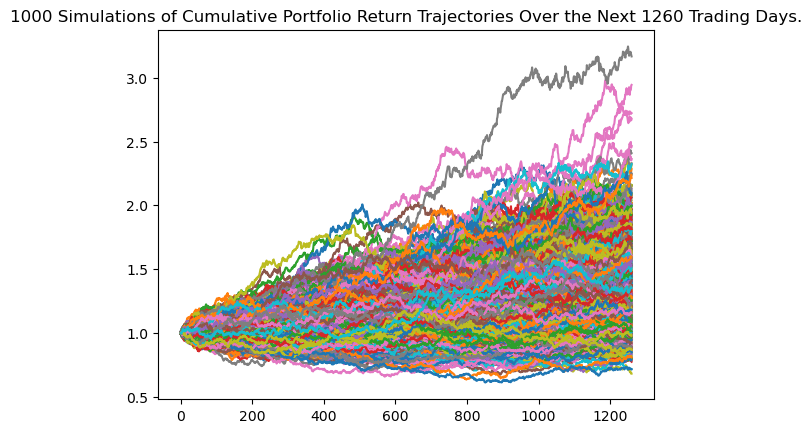

In [38]:
# Run a Monte Carlo simulation to forecast five years cumulative returns
### ***NOTE*** WE NEED TO USE HVPLOT
# Plot simulation outcomes
line_plot = MC_port_two.plot_simulation()

#change the _fiveyear_ sim in the string to reflect the sim length
line_plot.get_figure().savefig('MC_port_two_fiveyear_sim_plot.png', bbox_inches='tight')


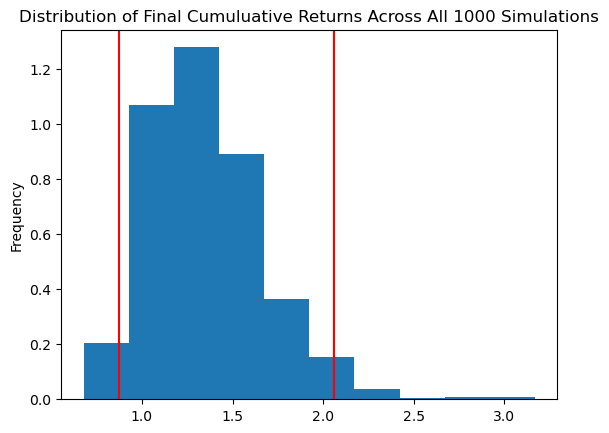

In [37]:
# Plot probability distribution and confidence intervals
dist_plot = MC_port_two.plot_distribution()

#change the _fiveyear_ sim in the string to reflect the sim length
dist_plot.get_figure().savefig('MC_port_two_fiveyear_dist_plot.png', bbox_inches = 'tight')

In [39]:
# Fetch summary statistics from the Monte Carlo simulation results

# Fetch summary statistics from the Monte Carlo simulation results
summary_metrics_port_two = MC_port_two.simulated_return.iloc[-1].describe()
ci_series_port_two = MC_port_two.confidence_interval
ci_series_port_two.index = ["95% CI Lower", "95% CI Upper"]

# Concatenate metrics and confidence interval series into a DataFrame
summary_df_port_two = pd.concat([summary_metrics_port_two, ci_series_port_two], axis=0)

# Print summary statistics with confidence intervals
print(summary_df_port_two)

count           1000.000000
mean               1.357433
std                0.317681
min                0.680331
25%                1.122237
50%                1.319898
75%                1.553399
max                3.167650
95% CI Lower       0.872807
95% CI Upper       2.062190
Name: 1260, dtype: float64


In [40]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments stocks
initial_investment = 15000
lower_bound_port_two = round((summary_df_port_two['95% CI Lower'] * initial_investment), 2)
upper_bound_port_two = round((summary_df_port_two['95% CI Upper'] * initial_investment), 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment}")
print(f"in the portofolio over the next 5 years will end within the range of ${lower_bound_port_two} and ${upper_bound_port_two}.")

sharpe_port_two = summary_df_port_two['mean']/summary_df_port_two['std']
print(f"this is your sharpe: {round(sharpe_port_two, 2)}, you make {round(sharpe_port_two,2)} units of return for every 1 unit of risk")

There is a 95% chance that an initial investment of $15000
in the portofolio over the next 5 years will end within the range of $13092.11 and $30932.84.
this is your sharpe: 4.27, you make 4.27 units of return for every 1 unit of risk


In [46]:
# Configure a Monte Carlo simulation to forecast specified years and num_sims cumulative returns

# specify the number of simulations to be run and the number of years to be forecast
num_sims = 1000
forecast_years = 5

MC_port_three = MCSimulation(monte_df, weights=portfolio_target_weights[3], num_simulation=num_sims, num_trading_days=252*forecast_years)

# Print the simulation input data
MC_port_three.portfolio_data.head()

ETH-USD                    BTC-USD                      IVE  \
                  close daily_return         close daily_return       close   
Date                                                                          
2021-05-10  3952.293945          NaN  55859.796875          NaN  150.610001   
2021-05-11  4168.701172     0.054755  56704.574219     0.015123  148.570007   
2021-05-12  3785.848633    -0.091840  49150.535156    -0.133217  145.990005   
2021-05-13  3715.148438    -0.018675  49716.191406     0.011509  147.979996   
2021-05-14  4079.057373     0.097953  49880.535156     0.003306  149.820007   

                               IVW                      SPY               \
           daily_return      close daily_return       close daily_return   
Date                                                                       
2021-05-10          NaN  67.940002          NaN  417.940002          NaN   
2021-05-11    -0.013545  67.650002    -0.004268  414.209991    -0.008925   
2021-05-12    -0.017366  65.959999    -0.024982  405.410004    -0.021245   
2021-05-13     0.013631  66.660004     0.010613  410.279999     0.012013   
2021-05-14     0.012434  67.889999     0.018452  416.579987     0.015355   

                 BNDX                      AGG               
                close daily_return       close daily_return  
Date                                                         
2021-05-10  56.910000          NaN  114.430000          NaN  
2021-05-11  56.779999    -0.002284  114.180000    -0.002185  
2021-05-12  56.619999    -0.002818  113.779999    -0.003503  
2021-05-13  56.639999     0.000353  114.040001     0.002285  
2021-05-14  56.709999     0.001236  114.300003     0.002280

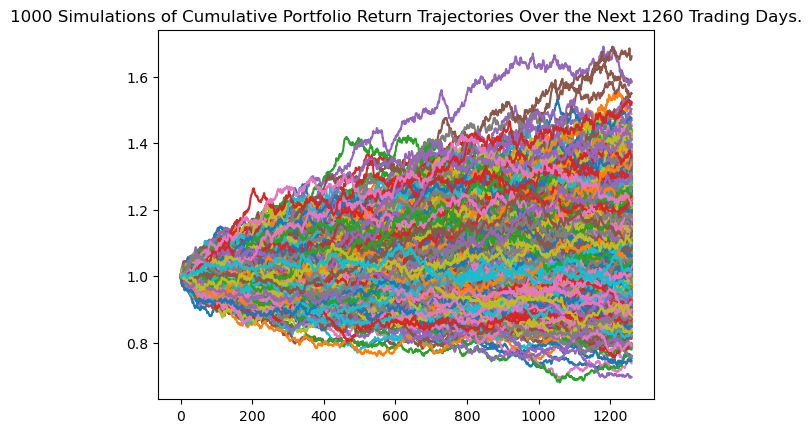

In [47]:
# Run a Monte Carlo simulation to forecast five years cumulative returns
### ***NOTE*** WE NEED TO USE HVPLOT
# Plot simulation outcomes
line_plot = MC_port_three.plot_simulation()

#change the _fiveyear_ sim in the string to reflect the sim length
line_plot.get_figure().savefig('MC_port_three_fiveyear_sim_plot.png', bbox_inches='tight')

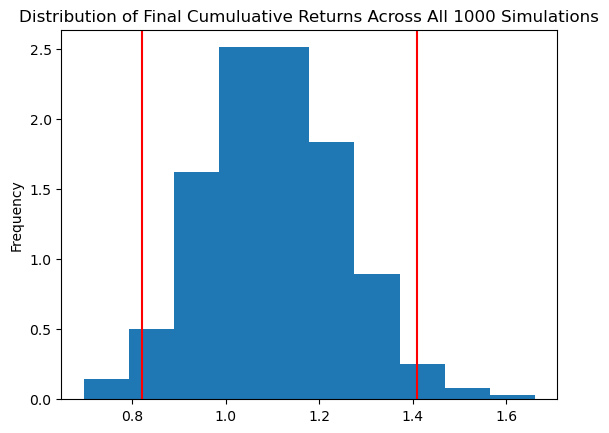

In [48]:
# Plot probability distribution and confidence intervals
dist_plot = MC_port_three.plot_distribution()

#change the _fiveyear_ sim in the string to reflect the sim length
dist_plot.get_figure().savefig('MC_port_three_fiveyear_dist_plot.png', bbox_inches = 'tight')

In [49]:
# Fetch summary statistics from the Monte Carlo simulation results

# Fetch summary statistics from the Monte Carlo simulation results
summary_metrics_port_three = MC_port_three.simulated_return.iloc[-1].describe()
ci_series_port_three = MC_port_three.confidence_interval
ci_series_port_three.index = ["95% CI Lower", "95% CI Upper"]

# Concatenate metrics and confidence interval series into a DataFrame
summary_df_port_three = pd.concat([summary_metrics_port_three, ci_series_port_three], axis=0)

# Print summary statistics with confidence intervals
print(summary_df_port_three)

count           1000.000000
mean               1.103506
std                0.146395
min                0.697436
25%                1.001038
50%                1.096748
75%                1.201262
max                1.660746
95% CI Lower       0.821283
95% CI Upper       1.409207
Name: 1260, dtype: float64


In [50]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments stocks
initial_investment = 15000
lower_bound_port_three = round((summary_df_port_three['95% CI Lower'] * initial_investment), 2)
upper_bound_port_three = round((summary_df_port_three['95% CI Upper'] * initial_investment), 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment}")
print(f"in the portofolio over the next 5 years will end within the range of ${lower_bound_port_three} and ${upper_bound_port_three}.")

sharpe_port_three = summary_df_port_three['mean']/summary_df_port_three['std']
print(f"this is your sharpe: {round(sharpe_port_three, 2)}, you make {round(sharpe_port_three,2)} units of return for every 1 unit of risk")

There is a 95% chance that an initial investment of $15000
in the portofolio over the next 5 years will end within the range of $12319.24 and $21138.11.
this is your sharpe: 7.54, you make 7.54 units of return for every 1 unit of risk


In [51]:
# Configure a Monte Carlo simulation to forecast specified years and num_sims cumulative returns

# specify the number of simulations to be run and the number of years to be forecast
num_sims = 1000
forecast_years = 5

MC_port_four = MCSimulation(monte_df, weights=portfolio_target_weights[4], num_simulation=num_sims, num_trading_days=252*forecast_years)

# Print the simulation input data
MC_port_four.portfolio_data.head()

ETH-USD                    BTC-USD                      IVE  \
                  close daily_return         close daily_return       close   
Date                                                                          
2021-05-10  3952.293945          NaN  55859.796875          NaN  150.610001   
2021-05-11  4168.701172     0.054755  56704.574219     0.015123  148.570007   
2021-05-12  3785.848633    -0.091840  49150.535156    -0.133217  145.990005   
2021-05-13  3715.148438    -0.018675  49716.191406     0.011509  147.979996   
2021-05-14  4079.057373     0.097953  49880.535156     0.003306  149.820007   

                               IVW                      SPY               \
           daily_return      close daily_return       close daily_return   
Date                                                                       
2021-05-10          NaN  67.940002          NaN  417.940002          NaN   
2021-05-11    -0.013545  67.650002    -0.004268  414.209991    -0.008925   
2021-05-12    -0.017366  65.959999    -0.024982  405.410004    -0.021245   
2021-05-13     0.013631  66.660004     0.010613  410.279999     0.012013   
2021-05-14     0.012434  67.889999     0.018452  416.579987     0.015355   

                 BNDX                      AGG               
                close daily_return       close daily_return  
Date                                                         
2021-05-10  56.910000          NaN  114.430000          NaN  
2021-05-11  56.779999    -0.002284  114.180000    -0.002185  
2021-05-12  56.619999    -0.002818  113.779999    -0.003503  
2021-05-13  56.639999     0.000353  114.040001     0.002285  
2021-05-14  56.709999     0.001236  114.300003     0.002280

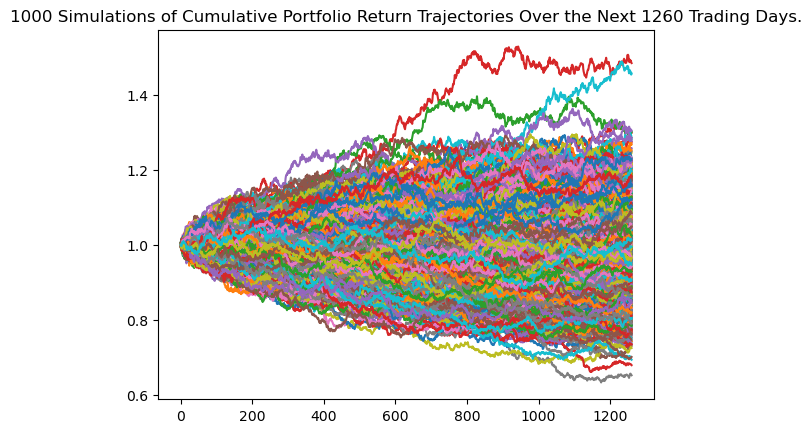

In [52]:
# Run a Monte Carlo simulation to forecast five years cumulative returns
### ***NOTE*** WE NEED TO USE HVPLOT
# Plot simulation outcomes
line_plot = MC_port_four.plot_simulation()

#change the _fiveyear_ sim in the string to reflect the sim length
line_plot.get_figure().savefig('MC_port_four_fiveyear_sim_plot.png', bbox_inches='tight')

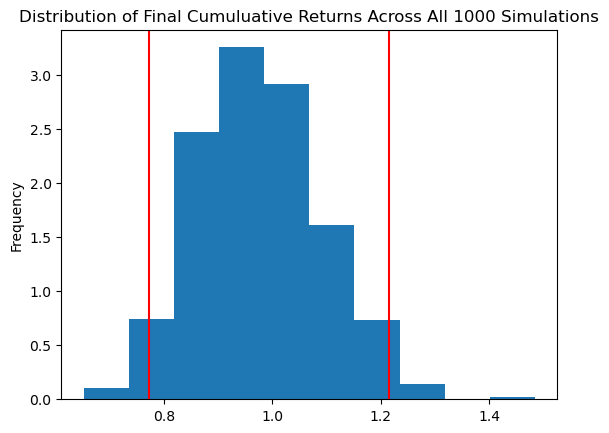

In [53]:
# Plot probability distribution and confidence intervals
dist_plot = MC_port_four.plot_distribution()

#change the _fiveyear_ sim in the string to reflect the sim length
dist_plot.get_figure().savefig('MC_port_four_fiveyear_dist_plot.png', bbox_inches = 'tight')

In [54]:
# Fetch summary statistics from the Monte Carlo simulation results

# Fetch summary statistics from the Monte Carlo simulation results
summary_metrics_port_four = MC_port_four.simulated_return.iloc[-1].describe()
ci_series_port_four = MC_port_four.confidence_interval
ci_series_port_four.index = ["95% CI Lower", "95% CI Upper"]

# Concatenate metrics and confidence interval series into a DataFrame
summary_df_port_four = pd.concat([summary_metrics_port_four, ci_series_port_four], axis=0)

# Print summary statistics with confidence intervals
print(summary_df_port_four)

count           1000.000000
mean               0.977315
std                0.114344
min                0.652504
25%                0.893396
50%                0.971549
75%                1.047566
max                1.483942
95% CI Lower       0.772696
95% CI Upper       1.215426
Name: 1260, dtype: float64


In [55]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments stocks
initial_investment = 15000
lower_bound_port_four = round((summary_df_port_four['95% CI Lower'] * initial_investment), 2)
upper_bound_port_four = round((summary_df_port_four['95% CI Upper'] * initial_investment), 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment}")
print(f"in the portofolio over the next 5 years will end within the range of ${lower_bound_port_four} and ${upper_bound_port_four}.")

sharpe_port_four = summary_df_port_four['mean']/summary_df_port_four['std']
print(f"this is your sharpe: {round(sharpe_port_four, 2)}, you make {round(sharpe_port_four,2)} units of return for every 1 unit of risk")

There is a 95% chance that an initial investment of $15000
in the portofolio over the next 5 years will end within the range of $11590.43 and $18231.39.
this is your sharpe: 8.55, you make 8.55 units of return for every 1 unit of risk


In [56]:
# Configure a Monte Carlo simulation to forecast specified years and num_sims cumulative returns

# specify the number of simulations to be run and the number of years to be forecast
num_sims = 1000
forecast_years = 5

MC_port_five = MCSimulation(monte_df, weights=portfolio_target_weights[5], num_simulation=num_sims, num_trading_days=252*forecast_years)

# Print the simulation input data
MC_port_five.portfolio_data.head()

ETH-USD                    BTC-USD                      IVE  \
                  close daily_return         close daily_return       close   
Date                                                                          
2021-05-10  3952.293945          NaN  55859.796875          NaN  150.610001   
2021-05-11  4168.701172     0.054755  56704.574219     0.015123  148.570007   
2021-05-12  3785.848633    -0.091840  49150.535156    -0.133217  145.990005   
2021-05-13  3715.148438    -0.018675  49716.191406     0.011509  147.979996   
2021-05-14  4079.057373     0.097953  49880.535156     0.003306  149.820007   

                               IVW                      SPY               \
           daily_return      close daily_return       close daily_return   
Date                                                                       
2021-05-10          NaN  67.940002          NaN  417.940002          NaN   
2021-05-11    -0.013545  67.650002    -0.004268  414.209991    -0.008925   
2021-05-12    -0.017366  65.959999    -0.024982  405.410004    -0.021245   
2021-05-13     0.013631  66.660004     0.010613  410.279999     0.012013   
2021-05-14     0.012434  67.889999     0.018452  416.579987     0.015355   

                 BNDX                      AGG               
                close daily_return       close daily_return  
Date                                                         
2021-05-10  56.910000          NaN  114.430000          NaN  
2021-05-11  56.779999    -0.002284  114.180000    -0.002185  
2021-05-12  56.619999    -0.002818  113.779999    -0.003503  
2021-05-13  56.639999     0.000353  114.040001     0.002285  
2021-05-14  56.709999     0.001236  114.300003     0.002280

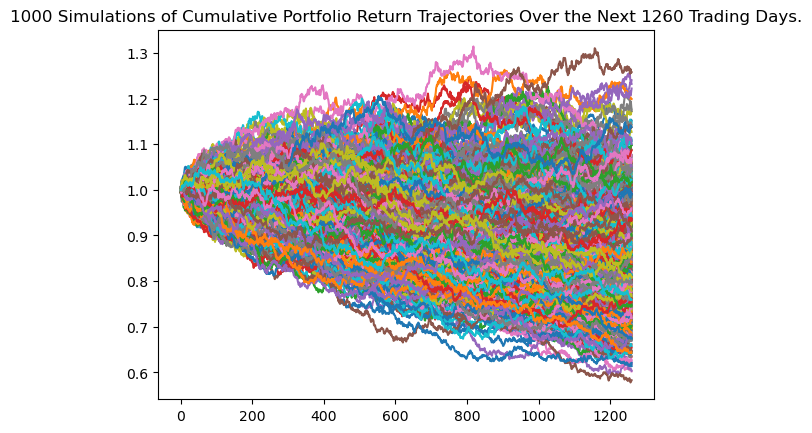

In [57]:
# Run a Monte Carlo simulation to forecast five years cumulative returns
### ***NOTE*** WE NEED TO USE HVPLOT
# Plot simulation outcomes
line_plot = MC_port_five.plot_simulation()

#change the _fiveyear_ sim in the string to reflect the sim length
line_plot.get_figure().savefig('MC_port_five_fiveyear_sim_plot.png', bbox_inches='tight')

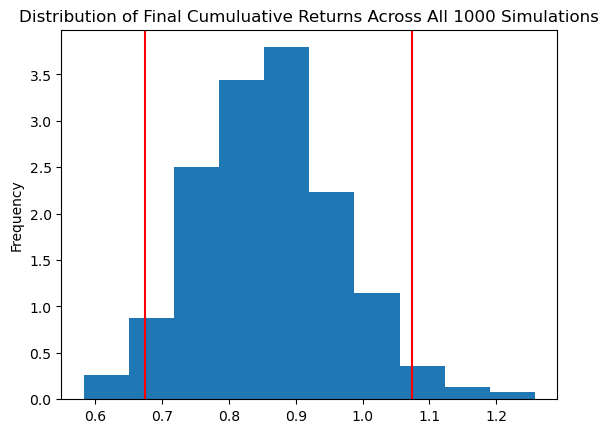

In [58]:
# Plot probability distribution and confidence intervals
dist_plot = MC_port_five.plot_distribution()

#change the _fiveyear_ sim in the string to reflect the sim length
dist_plot.get_figure().savefig('MC_port_five_fiveyear_dist_plot.png', bbox_inches = 'tight')

In [59]:
# Fetch summary statistics from the Monte Carlo simulation results

# Fetch summary statistics from the Monte Carlo simulation results
summary_metrics_port_five = MC_port_five.simulated_return.iloc[-1].describe()
ci_series_port_five = MC_port_five.confidence_interval
ci_series_port_five.index = ["95% CI Lower", "95% CI Upper"]

# Concatenate metrics and confidence interval series into a DataFrame
summary_df_port_five = pd.concat([summary_metrics_port_five, ci_series_port_five], axis=0)

# Print summary statistics with confidence intervals
print(summary_df_port_five)

count           1000.000000
mean               0.860331
std                0.104861
min                0.582837
25%                0.787116
50%                0.855396
75%                0.926943
max                1.257970
95% CI Lower       0.673624
95% CI Upper       1.074635
Name: 1260, dtype: float64


In [60]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments stocks
initial_investment = 15000
lower_bound_port_five = round((summary_df_port_five['95% CI Lower'] * initial_investment), 2)
upper_bound_port_five = round((summary_df_port_five['95% CI Upper'] * initial_investment), 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment}")
print(f"in the portofolio over the next 5 years will end within the range of ${lower_bound_port_five} and ${upper_bound_port_five}.")

sharpe_port_five = summary_df_port_five['mean']/summary_df_port_five['std']
print(f"this is your sharpe: {round(sharpe_port_five, 2)}, you make {round(sharpe_port_five,2)} units of return for every 1 unit of risk")

There is a 95% chance that an initial investment of $15000
in the portofolio over the next 5 years will end within the range of $10104.36 and $16119.53.
this is your sharpe: 8.2, you make 8.2 units of return for every 1 unit of risk


In [61]:
# set equal portfolio metrics
risk_reward_port_one = round((upper_bound_port_one - initial_investment)/abs(lower_bound_port_one - initial_investment), 2)
sharpe_port_one = summary_df_port_one['mean']/summary_df_port_one['std']
risk_adjusted_efficiency_port_one = round((risk_reward_port_one / sharpe_port_one), 2)

# set heavy ticker_one metrics
risk_reward_port_two = round((upper_bound_port_two - initial_investment)/abs(lower_bound_port_two - initial_investment), 2)
sharpe_port_two = summary_df_port_two['mean']/summary_df_port_two['std']
risk_adjusted_efficiency_port_two = round((risk_reward_port_two / sharpe_port_two), 2)

# set heavy ticker_two metrics
risk_reward_port_three = round((upper_bound_port_three - initial_investment)/abs(lower_bound_port_three - initial_investment), 2)
sharpe_port_three = summary_df_port_three['mean']/summary_df_port_three['std']
risk_adjusted_efficiency_port_three = round((risk_reward_port_three / sharpe_port_three), 2)

# set heavy ticker_three metrics
risk_reward_port_four = round((upper_bound_port_four - initial_investment)/abs(lower_bound_port_four - initial_investment), 2)
sharpe_port_four = summary_df_port_four['mean']/summary_df_port_four['std']
risk_adjusted_efficiency_port_four = round((risk_reward_port_four / sharpe_port_four), 2)

# set heavy ticker_three metrics
risk_reward_port_five = round((upper_bound_port_five - initial_investment)/abs(lower_bound_port_five - initial_investment), 2)
sharpe_port_five = summary_df_port_five['mean']/summary_df_port_five['std']
risk_adjusted_efficiency_port_five = round((risk_reward_port_five / sharpe_port_five), 2)

In [62]:
print(f"Initial Investment: ${initial_investment}")

print("--------------")
print(f'Upper and Lower Bounds of Portfolio 1: ${upper_bound_port_one} and ${lower_bound_port_one}')
print(f"Portfolio 1 Max Profit: ${upper_bound_port_one - initial_investment}")
print(f"Portfolio 1 Max Loss: $ {lower_bound_port_one - initial_investment}")
print(f"Portfolio 1 Risk-Reward Ratio: {risk_reward_port_one}")
print(f"Portfolio 1 Simulation Sharpe: {round(sharpe_port_one, 2)}")
print(f"Portfolio 1 Risk-Adjusted Efficiency: {risk_adjusted_efficiency_port_one}")

print("--------------")
print(f'Upper and Lower Bounds of Portfolio 2: ${upper_bound_port_two} and ${lower_bound_port_two}')
print(f"Portfolio 2 Max Profit: ${upper_bound_port_two - initial_investment}")
print(f"Portfolio 2 Max Loss: $ {lower_bound_port_two - initial_investment}")
print(f"Portfolio 2 Risk-Reward Ratio: {risk_reward_port_two}")
print(f"Portfolio 2 Simulation Sharpe: {round(sharpe_port_two, 2)}")
print(f"Portfolio 2 Risk-Adjusted Efficiency: {risk_adjusted_efficiency_port_two}")

print("--------------")
print(f'Upper and Lower Bounds of Portfolio 3: ${upper_bound_port_three} and ${lower_bound_port_three}')
print(f"Portfolio 3 Max Profit: ${upper_bound_port_three - initial_investment}")
print(f"Portfolio 3 Max Loss: $ {lower_bound_port_three - initial_investment}")
print(f"Portfolio 3 Risk-Reward Ratio: {risk_reward_port_three}")
print(f"Portfolio 3 Simulation Sharpe: {round(sharpe_port_three, 2)}")
print(f"Portfolio 3 Risk-Adjusted Efficiency: {risk_adjusted_efficiency_port_three}")

print("--------------")
print(f'Upper and Lower Bounds of Portfolio 4: ${upper_bound_port_four} and ${lower_bound_port_four}')
print(f"Portfolio 4 Max Profit: ${upper_bound_port_four - initial_investment}")
print(f"Portfolio 4 Max Loss: $ {lower_bound_port_four - initial_investment}")
print(f"Portfolio 4 Risk-Reward Ratio: {risk_reward_port_four}")
print(f"Portfolio 4 Simulation Sharpe: {round(sharpe_port_four, 2)}")
print(f"Portfolio 4 Risk-Adjusted Efficiency: {risk_adjusted_efficiency_port_four}")

print("--------------")

print(f"Upper and Lower Bounds of Portfolio 5: ${upper_bound_port_five} and ${lower_bound_port_five}")
print(f"Portfolio 5 Max Profit: ${upper_bound_port_five - initial_investment}")
print(f"Portfolio 5 Max Loss: $ {lower_bound_port_five - initial_investment}")
print(f"Portfolio 5 Risk-Reward Ratio: {risk_reward_port_five}")
print(f"Portfolio 5 Simulation Sharpe: {round(sharpe_port_five, 2)}")
print(f"Portfolio 5 Risk-Adjusted Efficiency: {risk_adjusted_efficiency_port_five}")

Initial Investment: $15000
--------------
Upper and Lower Bounds of Portfolio 1: $48469.38 and $10453.87
Portfolio 1 Max Profit: $33469.38
Portfolio 1 Max Loss: $ -4546.129999999999
Portfolio 1 Risk-Reward Ratio: 7.36
Portfolio 1 Simulation Sharpe: 2.5
Portfolio 1 Risk-Adjusted Efficiency: 2.95
--------------
Upper and Lower Bounds of Portfolio 2: $30932.84 and $13092.11
Portfolio 2 Max Profit: $15932.84
Portfolio 2 Max Loss: $ -1907.8899999999994
Portfolio 2 Risk-Reward Ratio: 8.35
Portfolio 2 Simulation Sharpe: 4.27
Portfolio 2 Risk-Adjusted Efficiency: 1.95
--------------
Upper and Lower Bounds of Portfolio 3: $21138.11 and $12319.24
Portfolio 3 Max Profit: $6138.110000000001
Portfolio 3 Max Loss: $ -2680.76
Portfolio 3 Risk-Reward Ratio: 2.29
Portfolio 3 Simulation Sharpe: 7.54
Portfolio 3 Risk-Adjusted Efficiency: 0.3
--------------
Upper and Lower Bounds of Portfolio 4: $18231.39 and $11590.43
Portfolio 4 Max Profit: $3231.3899999999994
Portfolio 4 Max Loss: $ -3409.5699999999997